<a href="https://colab.research.google.com/github/Maliha861/Maliha_WeatherWise-Assignment/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [50]:
# Optional packages — uncomment if needed in Colab or JupyterHub
!pip install fetch-my-weather
!pip install hands-on-ai

In [ ]:
import os

os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'
os.environ['HANDS_ON_AI_API_KEY'] = input('Enter your API key: ')

## 📦 Setup and Configuration
Import required packages and setup environment.

In [51]:
import requests                      # For making API calls to wttr.in
import matplotlib.pyplot as plt      # For creating weather visualisations (line and bar charts)
import pyinputplus as pyip           # For building an interactive menu-based user interface
import re                            # For natural language question parsing
import json                          # (Optional) For inspecting JSON structure
import sys                           # (Optional) For checking Python version and debugging

# AI tools (optional)
# If you're not using these, you can comment them out.
# Import after installing (if needed)
from fetch_my_weather import get_weather      # Optional helper library
from hands_on_ai.chat import get_response     # Optional AI chat helper

# Global constants
WTTR_BASE = "https://wttr.in"        # Base API URL for weather data
DEFAULT_LOCATION = "Perth"           # Default city if none is provided by user
DEFAULT_FORECAST_DAYS = 5            # Default forecast days (1–5 as per assignment)
UNITS = "m"                          # Default unit system: "m" = metric, "u" = US, "M" = metric + m/s wind

# Quick environment check
print("Environment setup complete.")
print("Python version:", sys.version)
print("Required libraries loaded successfully.")

Environment setup complete.
Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Required libraries loaded successfully.


## 🌤️ Weather Data Functions

In [63]:
# 🌤️ Weather Data Functions
# -------------------------
# Retrieve and process weather data from wttr.in and structure it for use
# in the Weather Advisor application.

import requests

def _safe_int(x, default=None):
    """Safely convert a value to int, returning a default if conversion fails."""
    try:
        return int(x)
    except Exception:
        return default

def _safe_float(x, default=None):
    """Safely convert a value to float, returning a default if conversion fails."""
    try:
        return float(x)
    except Exception:
        return default

def get_weather_data(location, forecast_days=3, units="m"):
    """
    Retrieve weather data for a specified location from wttr.in and normalise it.

    Args:
        location (str): City or location name.
        forecast_days (int): Number of days to forecast (1–5). wttr.in returns up to 3 days.
        units (str): Unit system ("m" = metric, "u" = US, "M" = metric + m/s wind).

    Returns:
        dict: Normalised weather data including current conditions and forecast,
              or an error dictionary if the request fails.
    """
    if not location or not isinstance(location, str):
        return {"error": "Please provide a valid location name."}

    # wttr.in JSON provides up to 3 days, so cap forecast_days here
    forecast_days = max(1, min(int(forecast_days), 3))

    base_url = f"https://wttr.in/{location}"
    params = {"format": "j1"}
    if units in ("m", "u", "M"):
        params[units] = ""  # wttr.in uses flags for unit selection

    try:
        response = requests.get(
            base_url,
            params=params,
            timeout=10,
            headers={
                "User-Agent": "Weather-Advisor/1.0 (Student Project)",
                "Accept": "application/json",
            },
        )
        response.raise_for_status()
        data = response.json()
    except requests.exceptions.RequestException as e:
        return {"error": f"Network or API error: {e}"}
    except ValueError:
        return {"error": "Invalid JSON response from wttr.in."}

    # Parse current conditions
    current_data = (data.get("current_condition") or [{}])[0]
    current = {
        "temp_c": _safe_int(current_data.get("temp_C")),
        "feels_like_c": _safe_int(current_data.get("FeelsLikeC")),
        "condition": ((current_data.get("weatherDesc") or [{}])[0].get("value")) or "N/A",
        "humidity": _safe_int(current_data.get("humidity")),
        "wind_kmph": _safe_int(current_data.get("windspeedKmph")),
        "wind_dir": current_data.get("winddir16Point") or "",
        "precip_mm": _safe_float(current_data.get("precipMM")),
        "uv_index": _safe_int(current_data.get("uvIndex")),
    }

    # Parse forecast data (up to 3 days)
    forecast_list = []
    for day in (data.get("weather") or [])[:forecast_days]:
        hourly = day.get("hourly") or []
        chance_of_rain = max((_safe_int(h.get("chanceofrain"), 0) for h in hourly), default=0)
        total_precip = sum((_safe_float(h.get("precipMM"), 0.0) for h in hourly))
        forecast_list.append({
            "date": day.get("date"),
            "min_c": _safe_int(day.get("mintempC")),
            "max_c": _safe_int(day.get("maxtempC")),
            "chance_of_rain": chance_of_rain,
            "precip_mm": round(total_precip, 1)
        })

    if not forecast_list:
        return {"error": "No forecast data returned for this location."}

    return {
        "location": location,
        "current": current,
        "forecast": forecast_list
    }

In [64]:
# Test the get_weather_data() function (3-day forecast from wttr.in)

import json

weather_data = get_weather_data("Perth", forecast_days=3, units="m")

print("Weather Data (3-Day Forecast):")
print(json.dumps(weather_data, indent=2))


Weather Data (3-Day Forecast):
{
  "location": "Perth",
  "current": {
    "temp_c": 19,
    "feels_like_c": 19,
    "condition": "Sunny",
    "humidity": 52,
    "wind_kmph": 16,
    "wind_dir": "SW",
    "precip_mm": 0.0,
    "uv_index": 2
  },
  "forecast": [
    {
      "date": "2025-09-30",
      "min_c": 12,
      "max_c": 18,
      "chance_of_rain": 84,
      "precip_mm": 0.0
    },
    {
      "date": "2025-10-01",
      "min_c": 13,
      "max_c": 19,
      "chance_of_rain": 71,
      "precip_mm": 0.0
    },
    {
      "date": "2025-10-02",
      "min_c": 12,
      "max_c": 23,
      "chance_of_rain": 0,
      "precip_mm": 0.0
    }
  ]
}


## 📊 Visualisation Functions

In [65]:
# Define create_temperature_visualisation() here

import matplotlib.pyplot as plt

def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of temperature data.

    Args:
        weather_data (dict): The processed weather data from get_weather_data()
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib Figure object.
        Otherwise, displays the visualisation in the notebook and returns None.
    """
    # Basic validation
    if not isinstance(weather_data, dict):
        raise TypeError("weather_data must be a dict as returned by get_weather_data().")
    if "error" in weather_data:
        print(weather_data["error"])
        return None
    if "forecast" not in weather_data or not weather_data["forecast"]:
        print("No forecast data available to plot.")
        return None

    # Extract series
    dates = [d.get("date", "") for d in weather_data["forecast"]]
    mins  = [d.get("min_c") for d in weather_data["forecast"]]
    maxs  = [d.get("max_c") for d in weather_data["forecast"]]

    # Build figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(dates, mins, marker="o", label="Min °C")
    ax.plot(dates, maxs, marker="o", label="Max °C")

    ax.set_title(f"Temperature Forecast — {weather_data.get('location','')}")
    ax.set_xlabel("Date")
    ax.set_ylabel("°C")
    ax.grid(True)
    ax.legend()

    if output_type == 'figure':
        return fig
    else:
        plt.show()
        plt.close(fig)
        return None


In [66]:
# Define create_precipitation_visualisation() here

import matplotlib.pyplot as plt

def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of precipitation data.

    Args:
        weather_data (dict): The processed weather data from get_weather_data()
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib Figure object.
        Otherwise, displays the visualisation in the notebook and returns None.
    """
    # Basic validation
    if not isinstance(weather_data, dict):
        raise TypeError("weather_data must be a dict as returned by get_weather_data().")
    if "error" in weather_data:
        print(weather_data["error"])
        return None
    if "forecast" not in weather_data or not weather_data["forecast"]:
        print("No forecast data available to plot.")
        return None

    dates = [d.get("date", "") for d in weather_data["forecast"]]
    # Use chance_of_rain (%) as the main precipitation indicator
    rain_prob = [d.get("chance_of_rain") for d in weather_data["forecast"]]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(dates, rain_prob)

    ax.set_title(f"Chance of Rain — {weather_data.get('location','')}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Chance of rain (%)")
    ax.grid(axis="y")

    if output_type == 'figure':
        return fig
    else:
        plt.show()
        plt.close(fig)
        return None


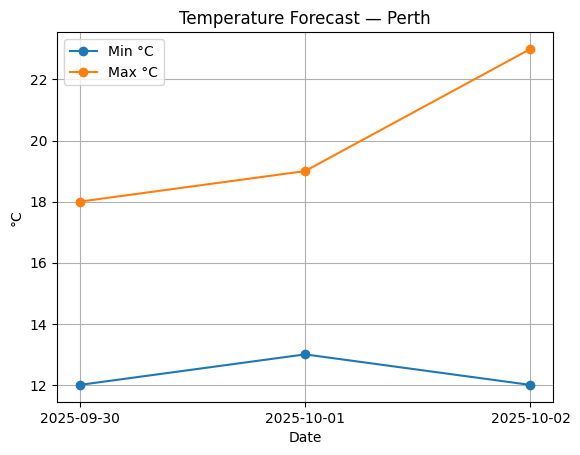

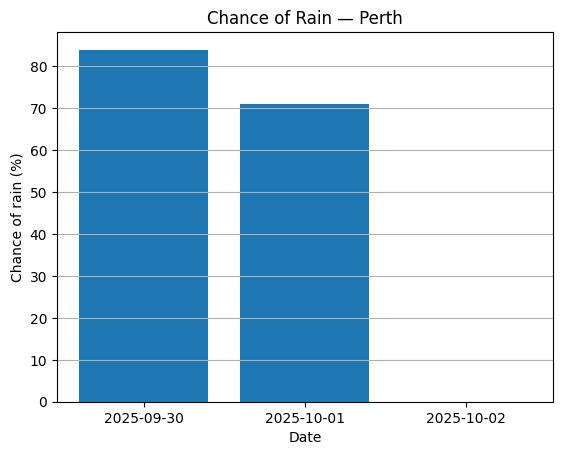

In [67]:
# Example weather data for testing
weather_example = {
  "location": "Perth",
  "current": {
    "temp_c": 19,
    "feels_like_c": 19,
    "condition": "Sunny",
    "humidity": 52,
    "wind_kmph": 16,
    "wind_dir": "SW",
    "precip_mm": 0.0,
    "uv_index": 2
  },
  "forecast": [
    {"date": "2025-09-30", "min_c": 12, "max_c": 18, "chance_of_rain": 84, "precip_mm": 0.0},
    {"date": "2025-10-01", "min_c": 13, "max_c": 19, "chance_of_rain": 71, "precip_mm": 0.0},
    {"date": "2025-10-02", "min_c": 12, "max_c": 23, "chance_of_rain": 0, "precip_mm": 0.0}
  ]
}

# Test visualisations
create_temperature_visualisation(weather_example)
create_precipitation_visualisation(weather_example)


## 🤖 Natural Language Processing

In [69]:
# Natural Language Processing
# ---------------------------
# Define parse_weather_question() and generate_weather_response() here

import re

# --- Internal helpers for NLP ---

_ATTR_ALIASES = {
    "rain": ["rain", "precip", "precipitation", "shower", "wet"],
    "temperature": ["temp", "temperature", "hot", "cold", "warm", "cool", "heat"],
    "wind": ["wind", "breeze", "gust"],
    "humidity": ["humidity", "humid"],
}

def _detect_attribute(q: str) -> str | None:
    ql = q.lower()
    for key, words in _ATTR_ALIASES.items():
        if any(w in ql for w in words):
            return key
    return None

def _detect_days_and_when(q: str) -> tuple[int, str]:
    """
    Returns (days, when_label)
      when_label in {"today","tomorrow","next"}
      days is clamped to 1..3 (wttr.in returns up to 3 days)
    """
    ql = q.lower()
    # explicit today/tomorrow
    if "today" in ql:
        return (1, "today")
    if "tomorrow" in ql:
        # ask for 2 days so we have today+tomorrow available for selection
        return (2, "tomorrow")

    # 'next N days'
    m = re.search(r"next\s+(\d+)\s+day", ql)
    if m:
        n = int(m.group(1))
        return (max(1, min(n, 3)), "next")

    # fallback 'this week' etc. -> treat as 3
    # or no time expression -> default to 3
    return (3, "next")

def _detect_location(q: str, fallback: str | None = None) -> str | None:
    """
    Extract a simple location after 'in' or 'for'.
    Example: 'Will it rain tomorrow in Perth?' -> 'Perth'
    """
    m = re.search(r"\b(?:in|for)\s+([A-Za-z][A-Za-z\s,.'-]{1,48})\b", q, re.IGNORECASE)
    if m:
        return m.group(1).strip()
    return fallback


# --- Public API ---

def parse_weather_question(question: str, default_location: str | None = None) -> dict:
    """
    Parse a natural-language weather question into structured intent.

    Args:
        question (str): User's weather-related question
        default_location (str|None): Used if no location phrase is found

    Returns:
        dict: {
          "location": str|None,
          "days": int (1..3),
          "attribute": "rain"|"temperature"|"wind"|"humidity"|None,
          "when": "today"|"tomorrow"|"next"
        }
        or {"error": "..."} on invalid input
    """
    if not question or not isinstance(question, str):
        return {"error": "Please provide a question string."}

    attribute = _detect_attribute(question)
    days, when = _detect_days_and_when(question)
    location = _detect_location(question, fallback=default_location)

    return {
        "location": location,
        "days": days,
        "attribute": attribute,
        "when": when
    }


def generate_weather_response(parsed: dict, weather_data: dict) -> str:
    """
    Generate a concise, human-readable answer from parsed intent and weather data.

    Args:
        parsed (dict): Output from parse_weather_question()
        weather_data (dict): Output from get_weather_data(location, days)

    Returns:
        str: Natural-language response
    """
    # Basic validation
    if not parsed or ("error" in parsed):
        return parsed.get("error", "I couldn't understand the question.")
    if not weather_data or ("error" in weather_data):
        return weather_data.get("error", "I couldn't retrieve weather data.")

    loc = weather_data.get("location") or parsed.get("location") or "the requested location"
    when = parsed.get("when", "next")
    attr = parsed.get("attribute")  # may be None

    # Forecast selection
    days = weather_data.get("forecast", [])
    if not days:
        return f"No forecast data available for {loc}."

    # Target day logic
    if when == "today":
        window = days[:1]
    elif when == "tomorrow":
        window = days[1:2] if len(days) >= 2 else days[:1]
    else:
        # 'next' -> use as many days as requested/available (already capped by get_weather_data)
        window = days

    # Aggregate helpers (defensive against None)
    def _min_val(k):
        vals = [d.get(k) for d in window if d.get(k) is not None]
        return min(vals) if vals else None

    def _max_val(k):
        vals = [d.get(k) for d in window if d.get(k) is not None]
        return max(vals) if vals else None

    def _sum_val(k):
        vals = [d.get(k) or 0 for d in window]
        return sum(vals) if vals else 0

    hi = _max_val("max_c")
    lo = _min_val("min_c")
    rainp = _max_val("chance_of_rain")
    precip = _sum_val("precip_mm")

    # Attribute-specific responses
    if attr == "rain":
        if len(window) == 1:
            d0 = window[0].get("date", "the day")
            rp = window[0].get("chance_of_rain")
            pm = window[0].get("precip_mm")
            rp_txt = f"{rp}%" if rp is not None else "unknown"
            pm_txt = f"{pm} mm" if pm is not None else "unknown"
            return f"In {loc} ({d0}), chance of rain is {rp_txt}, expected precipitation {pm_txt}."
        return (f"In {loc} over the {len(window)}-day period, the maximum chance of rain is "
                f"{rainp}% with a total of {precip:.1f} mm expected.")

    if attr == "temperature":
        if len(window) == 1:
            d0 = window[0].get("date", "the day")
            return f"In {loc} ({d0}), expect a high near {hi}°C and a low around {lo}°C."
        return (f"In {loc} over the next {len(window)} day(s), highs up to ~{hi}°C "
                f"and lows down to ~{lo}°C.")

    if attr == "wind":
        c = weather_data.get("current", {})
        ws = c.get("wind_kmph")
        wd = c.get("wind_dir", "")
        if ws is not None:
            return f"In {loc} {when}, current winds are about {ws} km/h {wd}."
        return f"In {loc} {when}, wind information is not available."

    if attr == "humidity":
        c = weather_data.get("current", {})
        h = c.get("humidity")
        if h is not None:
            return f"In {loc} {when}, current humidity is approximately {h}%."
        return f"In {loc} {when}, humidity information is not available."

    # Generic fallback summary
    cond = (weather_data.get("current") or {}).get("condition", "").lower() or "current conditions"
    if len(window) == 1:
        d0 = window[0].get("date", "the day")
        return (f"In {loc} ({d0}), it is {cond} with a high near {hi}°C, low around {lo}°C, "
                f"and up to {rainp}% chance of rain (≈{precip:.1f} mm total).")
    return (f"In {loc} over the next {len(window)} day(s), expect {cond}, highs up to ~{hi}°C, "
            f"lows near ~{lo}°C, and up to {rainp}% chance of rain (≈{precip:.1f} mm total).")


## 🧭 User Interface

In [80]:
# User Interface
# --------------
# Full CLI menu using pyinputplus, with a personal welcome banner.

import pyinputplus as pyip

def _print_welcome(app_name="Weather Advisor", user_name=None, location=None, units="m", forecast_days=3):
    """Print a welcome banner and current settings."""
    title = f"🌤️  Welcome to {app_name}" if not user_name else f"🌤️  Welcome to {app_name}, {user_name}"
    print("\n" + title)
    print("=" * len(title))
    unit_label = {"m": "Metric (°C, km/h)", "u": "US (°F, mph)", "M": "Metric (°C, m/s)"}.get(units, units)
    parts = []
    if location:
        parts.append(f"Location: {location}")
    parts.append(f"Units: {unit_label}")
    parts.append(f"Forecast days: {forecast_days}")
    print(" | ".join(parts) + "\n")

def _print_current(weather_data: dict) -> None:
    """Pretty-print current conditions block."""
    if not isinstance(weather_data, dict) or "error" in weather_data:
        print(weather_data.get("error", "No data available."))
        return
    cur = weather_data.get("current", {}) or {}
    print(f"\nCurrent weather — {weather_data.get('location','')}")
    print(f"  Condition : {cur.get('condition','N/A')}")
    print(f"  Temp      : {cur.get('temp_c','?')}°C (feels {cur.get('feels_like_c','?')}°C)")
    print(f"  Humidity  : {cur.get('humidity','?')}%")
    print(f"  Wind      : {cur.get('wind_kmph','?')} km/h {cur.get('wind_dir','')}")
    print(f"  Precip    : {cur.get('precip_mm','?')} mm")
    print(f"  UV Index  : {cur.get('uv_index','?')}\n")

def _print_forecast(weather_data: dict) -> None:
    """Pretty-print multi-day forecast lines."""
    if not isinstance(weather_data, dict) or "error" in weather_data:
        print(weather_data.get("error", "No data available."))
        return
    rows = weather_data.get("forecast", []) or []
    if not rows:
        print("No forecast data available.")
        return
    print(f"\nForecast — {weather_data.get('location','')}")
    for d in rows:
        print(f"  {d.get('date','YYYY-MM-DD')}: "
              f"Min {d.get('min_c','?')}°C / Max {d.get('max_c','?')}°C | "
              f"Rain {d.get('chance_of_rain','?')}% | {d.get('precip_mm','?')} mm")
    print("")

def main_menu(default_location: str = "Perth") -> None:
    """
    Interactive CLI menu for Weather Advisor.

    Requires these functions defined earlier:
      - get_weather_data(location, forecast_days=3, units="m")
      - create_temperature_visualisation(weather_data)
      - create_precipitation_visualisation(weather_data)
      - parse_weather_question(question, default_location=None)
      - generate_weather_response(parsed, weather_data)
    """
    location = default_location
    units = "m"          # "m" (metric), "u" (US), "M" (metric + wind m/s)
    forecast_days = 3    # wttr.in returns up to 3 days

    # Optional personalisation
    user_name = pyip.inputStr("Enter your name (optional, press Enter to skip): ", blank=True)
    _print_welcome(user_name=(user_name or None), location=location, units=units, forecast_days=forecast_days)

    while True:
        choice = pyip.inputMenu(
            [
                "Set/Change location",
                "Show current conditions",
                "Show forecast + charts",
                "Ask a weather question",
                "Settings",
                "Exit"
            ],
            numbered=True
        )

        if choice == "Set/Change location":
            loc = pyip.inputStr("Enter city/suburb (e.g., Perth): ").strip()
            if loc:
                location = loc
                print(f"Location set to: {location}")
                _print_welcome(user_name=(user_name or None), location=location, units=units, forecast_days=forecast_days)

        elif choice == "Show current conditions":
            data = get_weather_data(location, forecast_days=1, units=units)
            _print_current(data)

        elif choice == "Show forecast + charts":
            data = get_weather_data(location, forecast_days=forecast_days, units=units)
            _print_forecast(data)
            create_temperature_visualisation(data)
            create_precipitation_visualisation(data)

        elif choice == "Ask a weather question":
            q = pyip.inputStr("Enter your question (e.g., 'Will it rain tomorrow in Perth?'): ").strip()
            if not q:
                print("Please enter a question.")
                continue
            parsed = parse_weather_question(q, default_location=location)
            loc_for_query = parsed.get("location") or location
            days_for_query = parsed.get("days", 3)
            data = get_weather_data(loc_for_query, forecast_days=days_for_query, units=units)
            print("\n" + generate_weather_response(parsed, data) + "\n")

        elif choice == "Settings":
            units_choice = pyip.inputMenu(
                ["m (metric °C, km/h)", "u (US °F, mph)", "M (metric+wind m/s)"],
                numbered=True
            )
            units = units_choice.split()[0]
            forecast_days = pyip.inputInt("Forecast days (1–3): ", min=1, max=3)
            print(f"Units set to: {units} | Forecast days set to: {forecast_days}")
            _print_welcome(user_name=(user_name or None), location=location, units=units, forecast_days=forecast_days)

        else:  # Exit
            print("Exiting Weather Advisor.")
            break


In [ ]:
# To start the interactive menu, run:
main_menu("Perth")

Enter your name (optional, press Enter to skip): Maliha

🌤️  Welcome to Weather Advisor, Maliha
Location: Perth | Units: Metric (°C, km/h) | Forecast days: 3

Please select one of the following:
1. Set/Change location
2. Show current conditions
3. Show forecast + charts
4. Ask a weather question
5. Settings
6. Exit
1
Enter city/suburb (e.g., Perth): Pert
Location set to: Pert

🌤️  Welcome to Weather Advisor, Maliha
Location: Pert | Units: Metric (°C, km/h) | Forecast days: 3

Please select one of the following:
1. Set/Change location
2. Show current conditions
3. Show forecast + charts
4. Ask a weather question
5. Settings
6. Exit
4
Enter your question (e.g., 'Will it rain tomorrow in Perth?'): Will it be sunny tomorrow?

In Pert (2025-10-01), it is sunny with a high near 16°C, low around 6°C, and up to 0% chance of rain (≈0.0 mm total).

Please select one of the following:
1. Set/Change location
2. Show current conditions
3. Show forecast + charts
4. Ask a weather question
5. Settings

## 🧩 Main Application Logic

In [ ]:
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response from parsed intent and normalised weather data.

    Expected parsed_question schema (from parse_weather_question):
      {
        "location": str|None,
        "days": int (1..3),
        "attribute": "rain"|"temperature"|"wind"|"humidity"|None,
        "when": "today"|"tomorrow"|"next"
      }

    Expected weather_data schema (from get_weather_data):
      {
        "location": str,
        "current": {
          "temp_c": int|None, "feels_like_c": int|None, "condition": str,
          "humidity": int|None, "wind_kmph": int|None, "wind_dir": str,
          "precip_mm": float|None, "uv_index": int|None
        },
        "forecast": [
          {"date": "YYYY-MM-DD", "min_c": int|None, "max_c": int|None,
           "chance_of_rain": int|None, "precip_mm": float|None},
          ...
        ]
      }
    """
    # Basic validation
    if not isinstance(parsed_question, dict) or not parsed_question:
        return "I couldn't understand the question."
    if not isinstance(weather_data, dict) or "error" in weather_data:
        return weather_data.get("error", "Sorry, I couldn't retrieve weather data.")

    loc = weather_data.get("location") or parsed_question.get("location") or "the requested location"
    when = parsed_question.get("when", "next")
    attr = parsed_question.get("attribute")

    forecast = weather_data.get("forecast") or []
    if not forecast:
        return f"No forecast data available for {loc}."

    # Select the time window
    if when == "today":
        window = forecast[:1]
    elif when == "tomorrow":
        window = forecast[1:2] if len(forecast) >= 2 else forecast[:1]
    else:  # "next" or unspecified
        n = parsed_question.get("days", len(forecast))
        window = forecast[:max(1, min(n, len(forecast)))]

    # Aggregation helpers
    def _vals(key):
        return [d.get(key) for d in window if d.get(key) is not None]

    def _min(key):
        v = _vals(key);  return min(v) if v else None

    def _max(key):
        v = _vals(key);  return max(v) if v else None

    def _sum(key):
        return sum((d.get(key) or 0) for d in window)

    hi = _max("max_c")
    lo = _min("min_c")
    rainp_max = _max("chance_of_rain")
    precip_sum = _sum("precip_mm")

    # Attribute-specific responses
    if attr == "rain":
        if len(window) == 1:
            d0 = window[0].get("date", "the day")
            rp = window[0].get("chance_of_rain")
            pm = window[0].get("precip_mm")
            rp_txt = f"{rp}%" if rp is not None else "unknown"
            pm_txt = f"{pm} mm" if pm is not None else "unknown"
            return f"In {loc} ({d0}), chance of rain is {rp_txt}, expected precipitation {pm_txt}."
        return (f"In {loc} over the next {len(window)} day(s), the maximum chance of rain is "
                f"{rainp_max}% with a total of ~{precip_sum:.1f} mm expected.")

    if attr == "temperature":
        if len(window) == 1:
            d0 = window[0].get("date", "the day")
            return f"In {loc} ({d0}), expect a high near {hi}°C and a low around {lo}°C."
        return (f"In {loc} over the next {len(window)} day(s), highs up to ~{hi}°C "
                f"and lows down to ~{lo}°C.")

    if attr == "wind":
        cur = weather_data.get("current") or {}
        ws = cur.get("wind_kmph")
        wd = cur.get("wind_dir", "")
        if ws is not None:
            return f"In {loc} {when}, current winds are about {ws} km/h {wd}."
        return f"In {loc} {when}, wind information is not available."

    if attr == "humidity":
        cur = weather_data.get("current") or {}
        h = cur.get("humidity")
        if h is not None:
            return f"In {loc} {when}, current humidity is approximately {h}%."
        return f"In {loc} {when}, humidity information is not available."

    # Generic fallback summary
    cond = (weather_data.get("current") or {}).get("condition", "current conditions").lower()
    if len(window) == 1:
        d0 = window[0].get("date", "the day")
        return (f"In {loc} ({d0}), it is {cond} with a high near {hi}°C, low around {lo}°C, "
                f"and up to {rainp_max}% chance of rain (≈{precip_sum:.1f} mm total).")
    return (f"In {loc} over the next {len(window)} day(s), expect {cond}, highs up to ~{hi}°C, "
            f"lows near ~{lo}°C, and up to {rainp_max}% chance of rain (≈{precip_sum:.1f} mm total).")



## 🧪 Testing and Examples

In [ ]:
# Include sample input/output for each function
print("Test 2: get_weather_data with invalid input (empty location)")
bad_data = get_weather_data("", 3)
print("Result:", bad_data)
print()

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.